In [1]:
import sys
sys.path.append('..')
import numpy as np
from scipy.io import savemat
from matplotlib.pyplot import *
from gui.TrajectoryFrame import TypePolynomialFlatness, TypeOperatingPoint

In [6]:
# flache Trajektorienplanung
traj_planner = TypeOperatingPoint()
for angle in range(0, 60, 5):
    traj_planner.elevation = angle
    traj_planner.travel = 0
    trajectory = traj_planner.generate()
    savemat(f"../matlab/static{angle}.mat", trajectory.to_dict())

In [13]:
# Benchmarking Trajektorie
traj_planner = TypePolynomialFlatness()
traj_planner.elevation_start = -10
traj_planner.elevation_end = 10
traj_planner.travel_start = 0
traj_planner.travel_end = 120
traj_planner.t_end = 20
trajectory = traj_planner.generate()
savemat(f"../matlab/e_-10_10_l_0_120_t_20.mat", traj_planner.generate().to_dict())

traj_planner.t_end = 15
savemat(f"../matlab/e_-10_10_l_0_120_t_15.mat", traj_planner.generate().to_dict())

traj_planner.t_end = 10
savemat(f"../matlab/e_-10_10_l_0_120_t_10.mat", traj_planner.generate().to_dict())

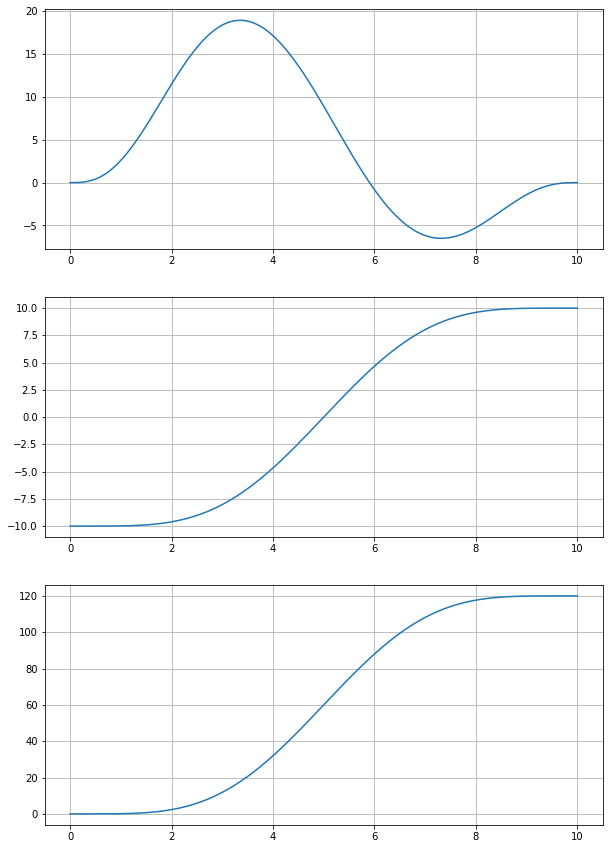

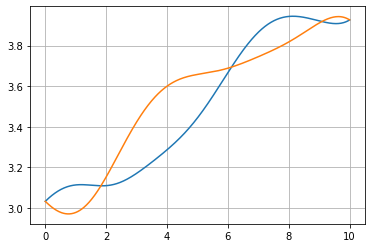

In [14]:
trajectory = traj_planner.generate()
deg = np.pi / 180
figure(figsize=(10, 15))
subplot(311)
plot(trajectory.t, trajectory.phi[:, 0] / deg)
grid()
subplot(312)
plot(trajectory.t, trajectory.eps[:, 0] / deg)
grid()
subplot(313)
plot(trajectory.t, trajectory.lamb[:, 0] / deg)
grid()

figure()
plot(trajectory.t, trajectory.vf)
plot(trajectory.t, trajectory.vb)
grid()
show()